In [1]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.mobilenet_v3 import preprocess_input
#from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [3]:
IM_SHAPE=(224,224)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [4]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#from keras.applications import DenseNet121

from keras.applications import mobilenet_v3
vgg = mobilenet_v3.MobileNetV3Small(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-02-04 04:53:47.771151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 04:53:47.873487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 04:53:47.874391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 04:53:47.876200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

6709248/6698480 [==============================] - 1s 0us/step


In [6]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fe0ce267c10>,input_1,False
1,<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fe0caa0cad0>,rescaling,False
2,<keras.layers.convolutional.Conv2D object at 0x7fe0caf3b450>,Conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0c97aef10>,Conv/BatchNorm,False
4,<keras.layers.core.TFOpLambda object at 0x7fe0c9809690>,tf.__operators__.add,False
...,...,...,...
231,<keras.layers.core.TFOpLambda object at 0x7fe0c8b50410>,tf.__operators__.add_27,False
232,<keras.layers.advanced_activations.ReLU object at 0x7fe0c8b6f4d0>,re_lu_32,False
233,<keras.layers.core.TFOpLambda object at 0x7fe0c8a4f510>,tf.math.multiply_27,False
234,<keras.layers.merge.Multiply object at 0x7fe0c8b6c590>,multiply_18,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


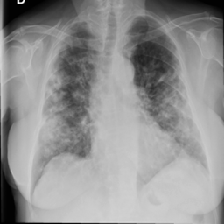

In [8]:
array_to_img(train_generator_NEW[0][0][0])

2023-02-04 04:53:54.217323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 04:53:55.821027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 1, 1, 1024)


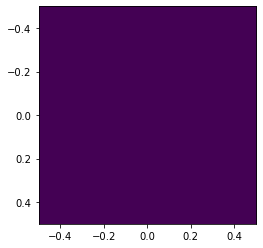

In [9]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [10]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
# model_TF.add(Dense(1024, activation='relu')) 
# model_TF.add(Dropout(0.25)) 
# model_TF.add(Dense(512, activation='relu')) 
# model_TF.add(Dropout(0.25))
# model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1024)              1529968   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 1,532,018
Trainable params: 2,050
Non-trainable params: 1,529,968
_________________________________________________________________


In [11]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [12]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 234s 512ms/step - loss: 0.7079 - accuracy: 0.5106 - f1_m: 0.6045 - precision_m: 0.5061 - recall_m: 0.7538 - val_loss: 0.6882 - val_accuracy: 0.7014 - val_f1_m: 0.6667 - val_precision_m: 0.5000 - val_recall_m: 1.0000
Epoch 2/15
452/452 [==============================] - 63s 140ms/step - loss: 0.6988 - accuracy: 0.5200 - f1_m: 0.6087 - precision_m: 0.5078 - recall_m: 0.7629 - val_loss: 0.6899 - val_accuracy: 0.4700 - val_f1_m: 0.6659 - val_precision_m: 0.4998 - val_recall_m: 0.9974
Epoch 3/15
452/452 [==============================] - 63s 140ms/step - loss: 0.6948 - accuracy: 0.5327 - f1_m: 0.6146 - precision_m: 0.5117 - recall_m: 0.7730 - val_loss: 0.6768 - val_accuracy: 0.5715 - val_f1_m: 0.6664 - val_precision_m: 0.4999 - val_recall_m: 0.9994
Epoch 4/15
452/452 [==============================] - 65s 144ms/step - loss: 0.6874 - accuracy: 0.5456 - f1_m: 0.6208 - precision_m: 0.5154 - recall_m: 0.7833 - val_loss: 0.6729 - val_accuracy: 0.5652 - 

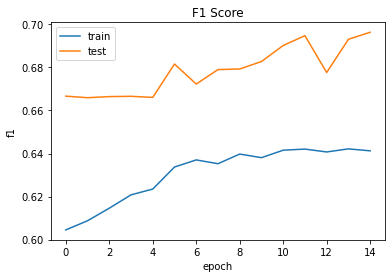

In [13]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 21s 339ms/step - loss: 0.6715 - accuracy: 0.5865 - f1_m: 0.6592 - precision_m: 0.5347 - recall_m: 0.8606


In [15]:
test_loss

[0.6714738011360168,
 0.5864999890327454,
 0.6592447757720947,
 0.5346574783325195,
 0.860615074634552]

In [16]:
from keras.applications import mobilenet_v3
dense =  mobilenet_v3.MobileNetV3Small(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True
dense_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [17]:
model = Sequential() 

model.add(dense_model) 
# model.add(Dense(1024, activation='relu')) 
# model.add(Dropout(0.25)) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1024)              1529968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 1,532,018
Trainable params: 1,519,906
Non-trainable params: 12,112
_________________________________________________________________


In [19]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 73s 150ms/step - loss: 0.3702 - accuracy: 0.8284 - f1_m: 0.8238 - precision_m: 0.7815 - recall_m: 0.8747 - val_loss: 1.1091 - val_accuracy: 0.5303 - val_f1_m: 0.5302 - val_precision_m: 0.5302 - val_recall_m: 0.5302
Epoch 2/15
452/452 [==============================] - 66s 145ms/step - loss: 0.1829 - accuracy: 0.9264 - f1_m: 0.9218 - precision_m: 0.9052 - recall_m: 0.9398 - val_loss: 1.6530 - val_accuracy: 0.5303 - val_f1_m: 0.5307 - val_precision_m: 0.5307 - val_recall_m: 0.5307
Epoch 3/15
452/452 [==============================] - 68s 150ms/step - loss: 0.1318 - accuracy: 0.9483 - f1_m: 0.9450 - precision_m: 0.9353 - recall_m: 0.9553 - val_loss: 1.7285 - val_accuracy: 0.5303 - val_f1_m: 0.5304 - val_precision_m: 0.5304 - val_recall_m: 0.5304
Epoch 4/15
452/452 [==============================] - 68s 151ms/step - loss: 0.1013 - accuracy: 0.9602 - f1_m: 0.9576 - precision_m: 0.9510 - recall_m: 0.9648 - val_loss: 2.0110 - val_accuracy:

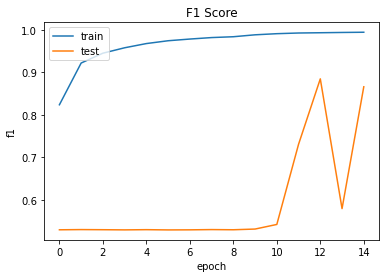

In [20]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 6s 92ms/step - loss: 0.3924 - accuracy: 0.8535 - f1_m: 0.8466 - precision_m: 0.8144 - recall_m: 0.8824


In [22]:
test_loss

[0.39237067103385925,
 0.8535000085830688,
 0.8465753793716431,
 0.814440131187439,
 0.882440447807312]